# Lecture 28 – CSCI 3022



[Acknowledgments Page](https://ds100.org/fa23/acks/)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
pd.options.mode.chained_assignment = None 
warnings.simplefilter(action='ignore', category=UserWarning)
np.random.seed(42)

## Feature Engineering

Feature engineering is the process of applying **feature functions** to generate new features for use in modeling. In this notebook, we will discuss:
* Feature transformations
* One-hot encoding
* Polynomial features


# Ex 1:  Bay Area Housing Data

For our first example we consider housing data scraped from the San Francisco Chronicle (SFChron) website. We restrict the data to houses sold in 2006, when sale prices were relatively stable, so we don’t need to account for trends in price. Since we have no plans to generalize our findings beyond the time period and the location and we are working with a census, the population matches the access frame and the sample consists of the entire population.

As for granularity, each record represents a sale of a home in the SF Bay Area during the specified time period. This means that if a home was sold twice during this time, then there are two records in the table. And if a home in the Bay Area was not up for sale during this time, then it does not appear in the dataset.

The data are in `BayAreaHousing.csv`

In [2]:
sfh=pd.read_csv("BayAreaHousing.csv")

sfh.head()

,date,city,price,br,lsqft,bsqft
0,2006-02-05,Berkeley,670000.0,3.0,3150.0,1119.0
1,2006-07-23,Berkeley,722000.0,2.0,5320.0,1394.0
2,2006-08-20,Berkeley,740000.0,4.0,4500.0,2065.0
3,2006-07-16,Berkeley,550000.0,2.0,2600.0,914.0
4,2006-08-13,Berkeley,601000.0,2.0,5320.0,940.0


In [3]:
sfh.describe()

,price,br,lsqft,bsqft
count,2.762000e+03,2667.000000,2762.000000,2762.000000
mean,7.390929e+05,3.019498,8019.136133,1615.614772
std,4.283536e+05,1.067663,9329.616159,766.239691
min,8.000000e+04,1.000000,468.000000,381.000000
25%,4.600000e+05,2.000000,3951.250000,1055.000000
50%,6.020000e+05,3.000000,5000.000000,1431.000000
75%,8.850000e+05,4.000000,7487.000000,1957.750000
max,3.980000e+06,16.000000,96703.000000,7468.000000


The data consists of the following columns:

`date`:  Date the house sold

`price`:  Price the house sold for

`city`:  In this case we consider 4 cities: Richmond, Berkeley, Piedmont and a combination of 3 cities Lafayette, Moraga and Morinda that we name Lamorinda

`br`:  Number of bedrooms

`lsqft`:  Square feet of the lot

`bsqft`:  Square feet of the house



## Choosing Features to Predict Sale Price

In [ ]:
# Plot Distribution of Sale Price - look for outliers or other 

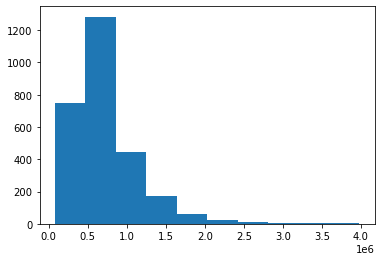

In [4]:
plt.hist(sfh["price"]);

In [ ]:
# The skewed distribution is hinting that our models will likely do better
# if we transform price to log(price)  (so that outliers don't overly influence the model)
plt.hist(np.log(sfh["price"]));

### Correlation: 

We can start by calculating the correlation between price and the available quantitative explantory variables, to see which one(s) it correlates most highly with. 


In [ ]:
sfh.corr()

Sale price correlates most highly with house size, called `bsqft` for building square feet. 
We confirm from our scatter plot of sale price against house size that the association is linear. 


### Visualizing Relationships between Price and possible explanatory quantitative features:

#### Price vs Square feet of the house

In [ ]:
# You can use the function below to plot all combinations at once:
#sns.pairplot(sfh)

px.scatter(sfh,sfh["bsqft"],sfh["price"])


#### Price vs Square feet of the lot

In [ ]:


px.scatter(sfh,sfh["lsqft"],sfh["price"])

#### Price vs Bedrooms

In [ ]:
px.scatter(sfh,sfh["br"],sfh["price"])

### Caution When not to use scatterplot:
Due to overplotting, it's better to use boxplots (or violin plots) to examine associations between variables when one of your variables is categorical or discrete with only a few values.
**CAVEAT** A boxplot/violin plot can be misleading if you only have a few data points for a given category - so notice for 7 or more bedrooms we should just plots the datapoints, and not the boxplots. 

In [ ]:
px.box(sfh,x=sfh["br"],y=sfh["price"])

## Feature Engineering 

### Examining feature that is most correlated with price:  bsqft

In [ ]:
px.scatter(sfh,sfh["bsqft"],sfh["price"])

The relationship between price and bsqft does look roughly linear, but the very large and expensive houses are far from the center of the distribution and can overly influence the model. 
Let's try a **log transformation of both variables** to make the distributions of price and size more symmetric.

In [5]:
sfh["log_price"]=np.log(sfh["price"])
sfh["log_bsqft"]=np.log(sfh["bsqft"])


In [ ]:
px.scatter(sfh,sfh["log_bsqft"],sfh["log_price"])

## First Version of Model:  Using the (transformed) predictor with the highest correlation to log(price)

Let's create a model of the form:  $$\text{log(price)} = \theta_0 + \theta_1 \text{log(bsqft)}$$

Ideally, a model that uses transformations should make sense in the context of the data. If we fit a simple linear model based on log(size), then when we examine the coefficient, we think in terms of a percentage increase. For example, a doubling of $x$ increases the prediction by $\theta \log(2)$, since $\theta \log(2x) = \theta\log(2) + \theta \log(x)$.

Let's begin by fitting a model that explains log-transformed price by the house's log-transformed size. But first, we note that this model is still considered a linear model. If we represent sale price by $y$ and house size by $x$, then the model is:

$$
\begin{aligned}
\log(y) ~&=~ \theta_0 + \theta_1\log(x) 
\end{aligned}
$$

(Note that we have ignored the approximation in this equation to make the linear relationship clearer.) This equation may not seem linear, but if we rename $\log(y)$ to $w$ and $\log(x)$ to $v$, then we can express this "log–log" relationship as a linear model in $w$ and $v$:

$$
w ~=~ \theta_0 + \theta_1 v
$$

Other examples of models that can be expressed as linear combinations of transformed features are:

$$
\begin{aligned}
\log(y) ~&=~ \theta_0 + \theta_1 x \\
y ~&=~ \theta_0 + \theta_1 x + \theta_2 x^2 \\
y ~&=~ \theta_0 + \theta_1 x + \theta_2 z  + \theta_3 x z  
\end{aligned}
$$

Again, if we rename $\log(y)$ to $w$, $x^2$ to $u$, and $x z$ as $t$, then we can express each of these models as linear in these renamed features. In order, the preceding models are now: 

$$
\begin{aligned}
w ~&=~ \theta_0 + \theta_1 x \\
y ~&=~ \theta_0 + \theta_1 x + \theta_2 u\\
y ~&=~ \theta_0 + \theta_1 x + \theta_2 z  + \theta_3 t \\ 
\end{aligned}
$$

In short, we can think of models that include nonlinear transformations of features and/or combinations of features as linear in their derived features. In practice, we don't rename the transformed features when we describe the model; instead, we write the model using the transformations of the original features because it's important to keep track of them, especially when interpreting the coefficients and checking residual plots.

When we refer to these models, we include mention of the transformations. That is, we call a model *log–log* when both the outcome and explanatory variables are log-transformed; we say it's *log–linear* when the outcome is log-transformed but not the explanatory variable; we describe a model as having *polynomial features* of, say, degree two, when the first and second power transformations of the explanatory variable are included; and we say a model includes an *interaction term* between two explanatory features when the product of these two features is included in the model.

Let's fit a log–log model of price on size:


i.e. we'll create a model of the form:  $$\text{log(price)} = \theta_0 + \theta_1 \text{log(bsqft)}$$


In [6]:
import sklearn.linear_model as lm

X1_log = sfh[['log_bsqft']]    
y_log = sfh['log_price']

model1 =lm.LinearRegression().fit(X1_log, y_log)

**Output Model Coefficients**:

In [7]:
#Output the coefficients of the model:
pd.DataFrame({"Feature":[X1_log.columns[0],"intercept"], "Model Coefficient":[model1.coef_[0],model1.intercept_]}).set_index("Feature")

,Model Coefficient
Feature,
log_bsqft,0.85251
intercept,7.17106


**Output RMSE**

The coefficients and predicted values from this model cannot be directly compared to a model fitted using linear features because the units are the log of dollars and log of square feet, not dollars and square feet. 

In [8]:
#Calculate RMSE
y=sfh['price']

y_hat_m1 = np.exp(model1.predict(X1_log))

print(f"The RMSE of the model is {np.sqrt(np.mean((y-y_hat_m1)**2))}")

The RMSE of the model is 288246.45595824544


**Plot Residuals**

Next, we examine the residuals and predicted values with a plot.  Note, when examining residuals we will keep the log/log scale as it's easier to see patterns.

Text(0.5, 1.0, 'Residuals vs. log(predicted price) (both in log units)')

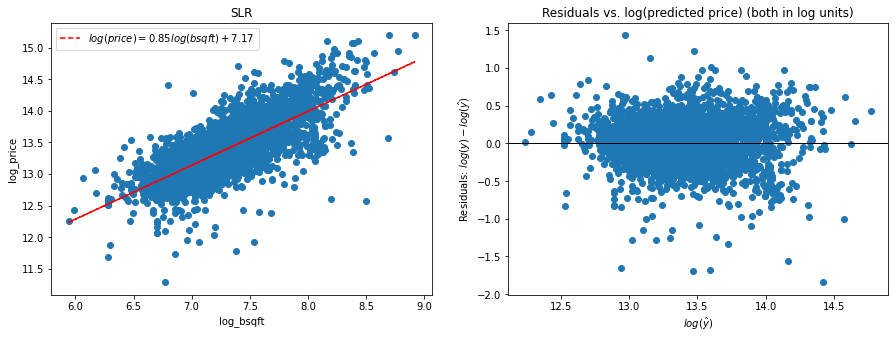

In [9]:
# We'll keep this in a log scale to better notice any patterns

prediction = model1.predict(X1_log)
error = sfh['log_price'] - prediction 

fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].scatter(sfh["log_bsqft"],sfh["log_price"])
ax[0].plot(sfh["log_bsqft"], prediction, 'r--', label =r'$log(price) = {0:.2f}log(bsqft)+{1:.2f}$'.format(model1.coef_[0],model1.intercept_))
ax[0].set_xlabel('log_bsqft')
ax[0].set_ylabel('log_price')
ax[0].set_title('SLR')
ax[0].legend()



ax[1].scatter(prediction, error)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'$log(\hat{y})$')
ax[1].set_ylabel(r'Residuals: $log(y) - log(\hat{y})$');
ax[1].set_title("Residuals vs. log(predicted price) (both in log units)")



The residual plot looks reasonable, but it contains thousands of points, which makes it hard to see curvature. 

Another way to examine the residuals is to plot the residuals vs actual price:

In [ ]:
fig = px.scatter(x=sfh['log_price'], y=error,
                 labels=dict(x='log(Actual sale price)', y='log(actual) - log(predicted)'))

fig.add_hline(0, line_width=2, line_dash='dash', opacity=1)
fig.show()

Notice that this shows that the model is _________ lower priced homes (predicting a Sale Price ________ than the actual Sale Price) and _______  higher priced homes

### Coefficient of Determination (i.e. Multiple R^2)

In SLR, $r^{2}$ (correlation squared) and Multiple $R^{2}$ are
equivalent.  

$$R^2 = \frac{\text{variance of fitted values}}{\text{variance of true } y} = \frac{\sigma_{\hat{y}}^2}{\sigma_y^2}$$

$R^2$  can be used
in the multiple regression setting, whereas $r$ (the correlation coefficient) is restricted to SLR since it depends on a single input feature.  

This number summarizes the amount of variation in the price that is being captured by the model.  The closer this is to 1, the better the model.

In [ ]:
r2_m1 = np.var(model1.predict(X1_log)) / np.var(sfh["log_price"])

print('Multiple R^2 for model1:  ', r2_m1)

In [ ]:
#Built-in function to calculate this:
model1.score(X1_log, sfh["log_price"])

In [ ]:
sfh.corr().loc["log_price","log_bsqft"]**2

## Feature Engineering:  Adding Qualitative Features



What about qualitative features?  There isn't a way to calculate a "correlation" between price and city. 

To see if additional qualitative variables might be helpful, we can plot the residuals from the fitted model against a variable that is not in the model. If we see patterns, that indicates we might want to include this additional feature or a transformation of it. 

In [ ]:
prediction = model1.predict(X1_log)
error = sfh['log_price'] - prediction 


sfh = sfh.assign(errors1_log=error)

In [ ]:
sfh.head()

In [ ]:
fig=px.scatter(sfh, x='city', y='errors1_log',
       category_orders={"city":["Piedmont","Lamorinda","Berkeley", "Richmond"]},
       labels=dict(errors1_log='Residuals (log USD)', city=''))

fig.add_hline(0, line_width=2, line_dash='dash', opacity=1)
fig.show()

In [ ]:
fig=px.box(sfh, x='city', y='errors1_log',
       category_orders={"city":["Piedmont","Lamorinda","Berkeley", "Richmond"]},
       labels=dict(errors1_log='Residuals (log USD)', city=''))

fig.add_hline(0, line_width=2, line_dash='dash', opacity=1)
fig.show()

This plot shows us that the distribution of errors appears shifted by city. Ideally, the median of each city's box plot lines up with 0 on the y-axis (meaning there was no difference in prediction by city). Instead, more than 75%  of the houses sold in  Piedmont have positive errors, meaning the actual sale price is above the predicted value. And at the other extreme, more than 75% of sale prices in Richmond fall below their predicted values. These patterns suggest that we should include city in the model. From a context point of view, it makes sense for location to impact sale price. In the next section, we show how to incorporate a nominal variable into a linear model. 

### One-Hot Encoding

One-hot encoding is a feature engineering technique to generate numeric feature from categorical data. For example, we can use one-hot encoding to incorporate the day of the week as an input into a regression model.



Suppose we want to use a design matrix of 2 features – the `log_bsqft` and `city` – to predict the price. 

In [10]:
X_raw = sfh[["log_bsqft","city"]]
y = sfh["log_price"]

Because `city` is non-numeric, we will apply one-hot encoding before fitting a model.

The `OneHotEncoder` class of `sklearn` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder.get_feature_names_out)) offers a quick way to perform one-hot encoding. For now, recognize that we follow a very similar workflow to when we were working with the `LinearRegression` class: we initialize a `OneHotEncoder` object, fit it to our data, then use `.transform` to apply the fitted encoder. 

In [11]:
from sklearn.preprocessing import OneHotEncoder

# Initialize a OneHotEncoder object
ohe = OneHotEncoder()

# Fit the encoder
ohe.fit(sfh[["city"]])

# Use the encoder to transform the raw "day" feature and put in a new dataframe

encoded_city_df = pd.DataFrame(ohe.transform(sfh[['city']]).todense(), 
                           columns=ohe.get_feature_names_out(),
                           index = sfh.index)


encoded_city_df

,city_Berkeley,city_Lamorinda,city_Piedmont,city_Richmond
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
2757,0.0,0.0,0.0,1.0
2758,0.0,0.0,0.0,1.0
2759,0.0,0.0,0.0,1.0
2760,0.0,0.0,0.0,1.0


The `OneHotEncoder` has converted the categorical `city` feature into four numeric features! 

Let's join this one-hot encoding to the original data to form our featurized design matrix. We drop the original `city` column so our design matrix only includes numeric values.

In [ ]:
X = X_raw.join(encoded_city_df).drop(columns="city")
X.head()

Now, we can use `sklearn`'s `LinearRegression` class to fit a model to this design matrix.


We're fitting a model of this form:

$$log(price) = \theta_1log(bsqft)+\theta_2(Berkeley)+\theta_3(Lamorinda)+\theta_4(Piedmont)+\theta_5(Richmond)$$



Notice, this is equivalent to fitting 4 models with the same slope, but the intercept term depending on city:

$$log(price) = \theta_1log(bsqft)+\theta_2 \hspace{5mm} \text{     (for houses in Berkeley)}$$

$$log(price) = \theta_1log(bsqft)+\theta_3  \hspace{5mm} \text{     (for houses in Lamorinda)}$$

$$log(price) = \theta_1log(bsqft)+\theta_4  \hspace{5mm} \text{     (for houses in Piedmont)}$$

$$log(price) = \theta_1log(bsqft)+\theta_5 \hspace{5mm}  \text{     (for houses in Richmond)}$$


In [ ]:
y = sfh["log_price"]

ohe_model = lm.LinearRegression(fit_intercept=False) 

#Since we are using one-hot encoding, tell sklearn to not add an additional intercept column. 

ohe_model.fit(X, y)

pd.DataFrame({"Feature":X.columns, "Model Coefficient":ohe_model.coef_}).set_index("Feature")

In [ ]:
#Calculate RMSE
y=sfh['price']

y_hat_m2 = np.exp(ohe_model.predict(X))

print(f"The RMSE of the model is {np.sqrt(np.mean((y-y_hat_m2)**2))}")

In [ ]:
# We'll keep this in a log scale to better notice any patterns
prediction = ohe_model.predict(X)
error = sfh['log_price'] - prediction 


In [ ]:
fig = px.scatter(x=prediction, y=error,
                 labels=dict(x='Predicted sale price (log USD)', y='Error'))

fig.add_hline(0, line_width=2, line_dash='dash', opacity=1)
fig.show()

In [ ]:
print(f"R-square for city and log(size):",
      f" {ohe_model.score(X, sfh['log_price']):.2f}")

In [ ]:
fig = px.scatter(x=sfh['log_price'], y=error,
                 labels=dict(x='Actual sale price (log USD)', y='Error (Log USD)'))

fig.add_hline(0, line_width=2, line_dash='dash', opacity=1)
fig.show()

# Ex 2:  


### Feature Engineering:  Adding Polynomial Features

Consider the `vehicles` dataset, which includes information about cars.

In [ ]:
vehicles = sns.load_dataset("mpg").dropna().rename(columns = {"horsepower": "hp"}).sort_values("hp")
vehicles.head()

Suppose we want to use the `hp` (horsepower) of a car to predict its `mpg` (gas mileage in miles per gallon). If we visualize the relationship between these two variables, we see a non-linear curvature. Fitting a linear model to these variables results in a high (poor) value of RMSE. 

$$\hat{y} = \theta_0 + \theta_1 (\text{hp})$$

In [ ]:
X = vehicles[["hp"]]
y = vehicles["mpg"]

hp_model = lm.LinearRegression()
hp_model.fit(X, y)
hp_model_predictions = hp_model.predict(X)

sns.scatterplot(data=vehicles, x="hp", y="mpg")

plt.plot(vehicles["hp"], hp_model_predictions, c="tab:red");

print(f"MSE of model with (hp) feature: {np.mean((y-hp_model_predictions)**2)}")

To capture the non-linear relationship between the variables, we can introduce a non-linear feature: `hp` squared. Our new model is:

$$\hat{y} = \theta_0 + \theta_1 (\text{hp}) + \theta_2 (\text{hp}^2)$$

In [ ]:
X = vehicles[["hp"]]
X.loc[:, "hp^2"] = vehicles["hp"]**2

hp2_model = lm.LinearRegression()
hp2_model.fit(X, y)
hp2_model_predictions = hp2_model.predict(X)

sns.scatterplot(data=vehicles, x="hp", y="mpg")

plt.plot(vehicles["hp"], hp2_model_predictions, c="tab:red");

print(f"MSE of model with (hp^2) feature: {np.mean((y-hp2_model_predictions)**2)}")

What if we take things further and add even *more* polynomial features?

The cell below fits models of increasing complexity and computes their MSEs.

In [ ]:
def mse(predictions, observations):
    return np.mean((observations - predictions)**2)

# Add hp^3 and hp^4 as features to the data
X["hp^3"] = vehicles["hp"]**3
X["hp^4"] = vehicles["hp"]**4

# Fit a model with order 3
hp3_model = lm.LinearRegression()
hp3_model.fit(X[["hp", "hp^2", "hp^3"]], vehicles["mpg"])
hp3_model_predictions = hp3_model.predict(X[["hp", "hp^2", "hp^3"]])

# Fit a model with order 4
hp4_model = lm.LinearRegression()
hp4_model.fit(X[["hp", "hp^2", "hp^3", "hp^4"]], vehicles["mpg"])
hp4_model_predictions = hp4_model.predict(X[["hp", "hp^2", "hp^3", "hp^4"]])

# Plot the models' predictions
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

predictions_dict = {0:hp2_model_predictions, 1:hp3_model_predictions, 2:hp4_model_predictions}

for i in predictions_dict:
    ax[i].scatter(vehicles["hp"], vehicles["mpg"], edgecolor="white", lw=0.5)
    ax[i].plot(vehicles["hp"], predictions_dict[i], "tab:red")
    ax[i].set_title(f"Model with order {i+2}")
    ax[i].set_xlabel("hp")
    ax[i].set_ylabel("mpg")
    ax[i].annotate(f"MSE: {np.round(mse(vehicles['mpg'], predictions_dict[i]), 3)}", (120, 40))

plt.subplots_adjust(wspace=0.3);

## Complexity and Overfitting

What we saw above was the phenomenon of **model complexity** – as we add additional features to the design matrix, the model becomes increasingly *complex*. Models with higher complexity have lower values of training error. Intuitively, this makes sense: with more features at its disposal, the model can match the observations in the trainining data more and more closely. 

We can run an experiment to see this in action. In the cell below, we fit many models of progressively higher complexity, then plot the MSE of predictions on the training set. The code used (specifically, the `Pipeline` and `PolynomialFeatures` functions of `sklearn`) is out of scope.

The **order** of a polynomial model is the highest power of any term in the model. An order 0 model takes the form $\hat{y} = \theta_0$, while an order 4 model takes the form $\hat{y} = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + \theta_4 x^4$.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model_dataset(degree, dataset):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', lm.LinearRegression())    
        ])

    pipelined_model.fit(dataset[["hp"]], dataset["mpg"])
    return mse(dataset['mpg'], pipelined_model.predict(dataset[["hp"]]))

errors = [fit_model_dataset(degree, vehicles) for degree in range(0, 8)]
MSEs_and_k = pd.DataFrame({"k": range(0, 8), "MSE": errors})

plt.plot(range(0, 8), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Training MSE");

def plot_degree_k_model(k, MSEs_and_k, axs):
    pipelined_model = Pipeline([
        ('poly_transform', PolynomialFeatures(degree = k)),
        ('regression', lm.LinearRegression(fit_intercept = True))    
    ])
    pipelined_model.fit(vehicles[["hp"]], vehicles["mpg"])
    
    row = k // 4
    col = k % 4
    ax = axs[row, col]
    
    sns.scatterplot(data=vehicles, x='hp', y='mpg', ax=ax)
    
    x_range = np.linspace(45, 210, 100).reshape(-1, 1)
    ax.plot(x_range, pipelined_model.predict(pd.DataFrame(x_range, columns=['hp'])), c='tab:red', linewidth=2)
    
    ax.set_ylim((0, 50))
    mse_str = f"MSE: {MSEs_and_k.loc[k, 'MSE']:.4}\nDegree: {k}"
    ax.text(130, 35, mse_str, dict(size=14))

fig = plt.figure(figsize=(15, 6), dpi=150)
axs = fig.subplots(nrows=2, ncols=4)

for k in range(8):
    plot_degree_k_model(k, MSEs_and_k, axs)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

As the model increases in polynomial degree (that is, it increases in complexity), the training MSE decreases, plateauing at roughly ~18.

In fact, it is a mathematical fact that if we create a polynomial model with degree $n-1$, we can *perfectly* model a set of $n$ points. For example, a set of 5 points can be perfectly modeled by a degree 4 model.

In [ ]:
np.random.seed(101)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for i in range(0, 3):
    points = 3*np.random.uniform(size=(5, 2))

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(4)),
                ('linear_regression', lm.LinearRegression())    
            ])

    polynomial_model.fit(points[:, [0]], points[:, 1])

    ax[i].scatter(points[:, 0], points[:, 1])

    xs = np.linspace(0, 3)
    ax[i].plot(xs, polynomial_model.predict(xs[:, np.newaxis]), c="tab:red");

You may be tempted to always design models with high polynomial degree – after all, we know that we could theoretically achieve perfect predictions by creating a model with enough polynomial features. 

It turns out that the examples we looked at above represent a somewhat artificial scenario: we trained our model on all the data we had available, then used the model to make predictions on this very same dataset. A more realistic situation is when we wish to apply our model on unseen data – that is, datapoints that it did not encounter during the model fitting process. 

Suppose we obtain a random sample of 6 datapoints from our population of vehicle data. We want to train a model on these 6 points and use it to make predictions on unseen data (perhaps cars for which we don't already know the true `mpg`). 

In [ ]:
np.random.seed(100)

sample_6 = vehicles.sample(6)

sns.scatterplot(data=sample_6, x="hp", y="mpg")
plt.ylim(-35, 50)
plt.xlim(0, 250);

If we design a model with polynomial degree 5, we can make perfect predictions on this sample of training data.

In [ ]:
degree_5_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(5)),
                ('linear_regression', lm.LinearRegression())    
            ])

degree_5_model.fit(sample_6[["hp"]], sample_6["mpg"])
xs = np.linspace(0, 250, 1000)
degree_5_model_predictions = degree_5_model.predict(xs[:, np.newaxis])

plt.plot(xs, degree_5_model_predictions, c="tab:red")
sns.scatterplot(data=sample_6, x="hp", y="mpg", s=50)
plt.ylim(-35, 50)
plt.xlim(0, 250);

However, when we reapply this fitted model to the full population of data, it fails to capture the major trends of the dataset.

In [ ]:
plt.plot(xs, degree_5_model_predictions, c="tab:red")
sns.scatterplot(data=vehicles, x="hp", y="mpg", s=50)
plt.ylim(-35, 50);

The model has **overfit** to the data used to train it. It has essentially "memorized" the six datapoints used during model fitting, and does not generalize well to new data. 

Complex models tend to be more sensitive to the data used to train them. The **variance** of a model refers to its tendency to vary depending on the training data used during model fitting. It turns out that our degree-5 model has very high model variance. If we randomly sample new sets of datapoints to use in training, the model varies erratically. 

In [ ]:
np.random.seed(100)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for i in range(0, 3):
    sample = vehicles.sample(6)

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(5)),
                ('linear_regression', lm.LinearRegression())    
            ])

    polynomial_model.fit(sample[["hp"]], sample["mpg"])

    ax[i].scatter(sample[["hp"]], sample["mpg"])

    xs = np.linspace(50, 210, 1000)
    ax[i].plot(xs, polynomial_model.predict(xs[:, np.newaxis]), c="tab:red")
    ax[i].set_ylim(-80, 100)
    ax[i].set_xlabel("hp")
    ax[i].set_ylabel("mpg")
    ax[i].set_title(f"Resample #{i+1}")
    
fig.tight_layout();